# 数据导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 300
import math
import datetime as dt
from tableone import TableOne, load_dataset
import itertools
import random
import scipy.stats as stats
import seaborn as sns

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df_type = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/df_mixAK_fea4_C3.csv")
df_type_filt = df_type.loc[:,["stay_id","groupHPD"]]
df_type_filt = df_type_filt.drop_duplicates()
all_lst = df_type_filt.stay_id.unique().tolist()
print("纳入患者数量：",len(all_lst))

df_type_filt["groupHPD"].value_counts()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


纳入患者数量： 4713


groupHPD
2    3055
1    1298
3     360
Name: count, dtype: int64

In [3]:
tmp = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
tmp.columns = ["groupHPD","count"]
tmp["count_all"] = len(all_lst)
tmp["Percentage"] = round(tmp["count"]/tmp["count_all"]*100,1)
#tmp =tmp.sort_values(["groupHPD"],ascending=False)
tmp

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,groupHPD,count,count_all,Percentage
0,2,3055,4713,64.8
1,1,1298,4713,27.5
2,3,360,4713,7.6


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/pylab/backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


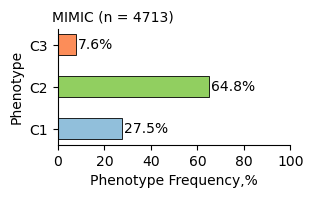

In [4]:
plt.figure(figsize=(3,1.5))
ax=plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.barh(tmp["groupHPD"].tolist(), tmp["Percentage"].tolist(),color=["#91cf60","#91bfdb","#fc8d59"],ec='black', ls='-', lw=0.6,height=0.5)
# color=["#91cf60","#91bfdb","#fc8d59"]
plt.xlabel("Phenotype Frequency,%")
plt.ylabel("Phenotype")
plt.yticks([1,2,3],[ 'C1', 'C2', 'C3'])
plt.xlim([0,100])
plt.title("MIMIC (n = 4713)",fontsize=10,horizontalalignment="right")
plt.text(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0]+1,3,str(tmp[tmp["groupHPD"]==3]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0]+1,2,str(tmp[tmp["groupHPD"]==2]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.text(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0]+1,1,str(tmp[tmp["groupHPD"]==1]["Percentage"].tolist()[0])+"%",verticalalignment="center")
plt.savefig("./result/MIMIC_phenotype_frequency.pdf")
plt.show()

# 预后 - 28d mortality 
- 28 day 死亡率
- 7 day 死亡率

In [5]:
# 数据准备
df_admit = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/df_mimic_basicinfo.csv")
df_admit = df_admit.loc[:,['stay_id',"dischtime","deathtime","hospital_expire_flag"]]
df_admit["deathtime"] = pd.to_datetime(df_admit["deathtime"])
df_admit["dischtime"] = pd.to_datetime(df_admit["dischtime"])

data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/"
infile = data_dir + "sk_event_time.csv"
df_time = pd.read_csv(infile)
df_time = df_time[df_time["stay_id"].isin(all_lst)]
df_time = df_time[["stay_id","saki_onset"]]
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])

df_admit = pd.merge(df_admit,df_time,how="inner",on="stay_id")
df_admit["hospital_survival_day"] = (df_admit["deathtime"] - df_admit["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_admit["hospital_survival_day_"] = (df_admit["dischtime"] - df_admit["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()

df_admit = df_admit.loc[:,['stay_id','hospital_survival_day',"hospital_expire_flag","hospital_survival_day_"]]
df_admit["hospital_survival_day"] = round(df_admit["hospital_survival_day"],0)
df_admit = pd.merge(df_admit, df_type_filt,how="inner",on="stay_id")
df_admit = df_admit.drop_duplicates()

# 28 day mortality
df_admit["mortality_28d"] = df_admit["hospital_expire_flag"]
df_admit["survival_28day"] = df_admit["hospital_survival_day"]
df_admit.loc[(df_admit["hospital_survival_day"]>=30), "mortality_28d"] = 0

df_admit["mortality_7d"] = df_admit["hospital_expire_flag"]
df_admit["survival_7day"] = df_admit["hospital_survival_day"] 
df_admit.loc[(df_admit["hospital_survival_day"]>=7), "mortality_7d"] = 0

df_admit["hospital_survival_day"].fillna(df_admit["hospital_survival_day_"], inplace=True)
df_admit["survival_7day"].fillna(df_admit["hospital_survival_day_"], inplace=True)
df_admit["survival_28day"].fillna(df_admit["hospital_survival_day_"], inplace=True)

df_admit.loc[df_admit["survival_28day"]>30, "survival_28day"] = 30
df_admit.loc[df_admit["survival_7day"]>7, "survival_7day"] = 7

df_admit.to_csv("sk_survival.csv", index=False)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-d6de4dff583d>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_admit["hospital_survival_day"].fillna(df_admit["hospital_survival_day

In [6]:
# 见R

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 特征描述-三组
- base info
    age
    gender
    weight
    los
    first_careunit

- labboratory vallues
    eGFR at baseline(ml/min/1.73m2)
    creatinine at baseline
    Maximum serum creatinine
    Urine Output
    
- AKI 
    first kdigo stages
    max kdigo stages

- ICU events（septic shock）
    机械通气
    液体复苏
    RRT
    kidney transplantation
    
- primary outcome
    28-dmortality
    renal recovery
    SAPS II score
    
- comorbidities
    Hypertension 
    Congestive heart failure 
    Diabetes mellitus 
    Liver disease 
    Peripheral vascular disease
    ...

In [7]:
df_demo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/df_mimic_basicinfo.csv")
df_demo = df_demo.loc[:,["stay_id",'gender', 'age','urgency', 'discharge_location', 'ethnicity','hospital_expire_flag','first_unittype',
                         'icu_stay_days','icu_expire_flag',"outtime"]]  
df_demo["outtime"] = pd.to_datetime(df_demo["outtime"] )
df_demo = df_demo[df_demo["stay_id"].isin(all_lst)]

# 加入类标签
df_demo_base_add = pd.merge(df_type_filt, df_demo, how="left", on = "stay_id")
df_demo_base_add = df_demo_base_add.drop_duplicates()

# 死亡率
df_admit = pd.read_csv("sk_survival.csv")
df_admit = df_admit.loc[:,["stay_id", "mortality_28d", "mortality_7d"]]
df_demo_base_add = pd.merge(df_admit, df_demo_base_add, how="inner", on = "stay_id")

# 加入基线肌酐
df_base_crea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/df_base_crea.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_base_crea, how="inner", on="stay_id")

# 加入peak and discharge肌酐
df_peak_discharge = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/df_peak_discharge.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_peak_discharge, how="left", on="stay_id")

# 加入AKI 诊断标准
df_criteria = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/AKI_diagnose_criteria.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_criteria, how="left", on="stay_id")

# 加入初次AKI和最高级AKI
df_sk_first_and_max_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage.csv")
df_sk_first_and_max_stage = df_sk_first_and_max_stage.loc[:,["stay_id","first_aki_onset","first_aki_stage", "max_aki_stage","aki_endstage","aki_endstage_H7D"]]
df_sk_first_and_max_stage["first_aki_onset"] = pd.to_datetime(df_sk_first_and_max_stage["first_aki_onset"])

df_demo_base_add = pd.merge(df_sk_first_and_max_stage, df_demo_base_add, how="inner", on = "stay_id")
df_demo_base_add["icu_stay_days_after_SAAKI"] = (df_demo_base_add["outtime"] - df_demo_base_add["first_aki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()

# AKI course
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/sk_first_and_max_stage.csv")
df_time["first_aki_onset"] = pd.to_datetime(df_time["first_aki_onset"] )
df_time["aki_endtime_H7D"] = pd.to_datetime(df_time["aki_endtime_H7D"] )

df_time["AKI_course"] = (df_time["aki_endtime_H7D"] - df_time["first_aki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_time = df_time[["stay_id","AKI_course"]]
df_demo_base_add = pd.merge(df_demo_base_add, df_time, how="left", on = "stay_id")

# 加入uo,crea最高级AKI
df_sk_first_and_max_stage_uc = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_first_and_max_stage_uo_crea.csv")
df_sk_first_and_max_stage_uc = df_sk_first_and_max_stage_uc.loc[:,["stay_id","max_aki_stage_uo", "max_aki_stage_crea" ]]
df_demo_base_add = pd.merge(df_sk_first_and_max_stage_uc, df_demo_base_add, how="inner", on = "stay_id")

# sepsi后多久发生aki
df_time = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/sk_event_time.csv")
df_time = df_time[df_time.stay_id.isin(all_lst)]
df_time["sepsis_onset"] = pd.to_datetime(df_time["sepsis_onset"] )
df_time["aki_onset"] = pd.to_datetime(df_time["aki_onset"] )
df_time["intime"] = pd.to_datetime(df_time["intime"] )
df_time["los_saki_minus_sepsis"] = (df_time["aki_onset"] - df_time["sepsis_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_time["los_aki_minus_intime"] = (df_time["aki_onset"] - df_time["intime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_time["los_sepsis_minus_intime"] = (df_time["sepsis_onset"] - df_time["intime"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_demo_base_add = pd.merge(df_demo_base_add, df_time, how="left", on = "stay_id")

#添加SA-AKI 类型
df_event = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_event = df_event[df_event.stay_id.isin(all_lst)]
df_event["sepsis_onset"] = pd.to_datetime(df_event["sepsis_onset"])
df_event["saki_onset"] = pd.to_datetime(df_event["saki_onset"])
df_event["los_sepsis_saaki"] = (df_event["saki_onset"] - df_event["sepsis_onset"]).map(lambda x:x/np.timedelta64(1, 'h')).tolist()
df_event.loc[df_event["los_sepsis_saaki"]<=48,"SA-AKI_type"] = "Early SA-AKI"
df_event.loc[df_event["los_sepsis_saaki"]>48,"SA-AKI_type"] = "Late SA-AKI"
df_event = df_event[['stay_id', 'los_sepsis_saaki','SA-AKI_type']]
df_demo_base_add = pd.merge(df_event, df_demo_base_add, how="inner", on = "stay_id")

# 共病
df_icd = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//diag_icd/df_mimic_diag_icd.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_icd, how="left",on="stay_id")
df_demo_base_add[['Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock']] = df_demo_base_add[['Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock']].fillna(0)
df_demo_base_add[df_icd.columns.tolist()] = df_demo_base_add[df_icd.columns.tolist()].astype("int")

# lifesupport
df_lifesupport = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/treatment/lifesupport.csv")
df_demo_base_add = pd.merge(df_demo_base_add, df_lifesupport, how="left", on = "stay_id")

# 绘制表格
columns = ["groupHPD",'age','gender',  'ethnicity','first_unittype','urgency', 
          'icu_stay_days',"icu_stay_days_after_SAAKI","AKI_course", 'hospital_expire_flag','icu_expire_flag',"mortality_28d", 'discharge_location','SA-AKI_type',
        'Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock','los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis',
           'baseline_Scr','Peak_Scr','Discharge_Scr','first_aki_stage', 'max_aki_stage',"max_aki_stage_uo", "max_aki_stage_crea" ,"aki_endstage","aki_endstage_H7D",  "AKI_criteria",
          'is_vaso', 'is_mv', 'is_rrt']
categorical = [
     'gender','ethnicity','first_unittype',
     'hospital_expire_flag','icu_expire_flag',"mortality_28d",'urgency', 'discharge_location','SA-AKI_type',
    'Myocardial_infarct', 'Congestive_heart_failure',
       'Peripheral_vascular_disease', 'Cerebrovascular_disease',
       'Pulmonary(chronic)', 'Peptic_ulcer', 'Renal', 'Hepatic', 'Tumor',
       'Cardiovascular', 'Acidosis', 'Cardiogenic_shock', 'Diabetes',
       'Hypertension', 'Respiratory_failure', 'Septic_shock',
    'first_aki_stage', 'max_aki_stage',"max_aki_stage_uo", "max_aki_stage_crea" ,"aki_endstage","aki_endstage_H7D",  "AKI_criteria",
    'is_vaso', 'is_mv', 'is_rrt'
]
nonnormal = ['age', 'icu_stay_days',"icu_stay_days_after_SAAKI",'los_sepsis_minus_intime','los_aki_minus_intime','los_saki_minus_sepsis',"AKI_course",'baseline_Scr','Peak_Scr','Discharge_Scr'] 
df_demo_stat = TableOne(df_demo_base_add, columns=columns, nonnormal=nonnormal, categorical=categorical, groupby = ["groupHPD"], pval=True)

df_demo_stat = pd.DataFrame(df_demo_stat.tableone).reset_index()
df_demo_stat = df_demo_stat.droplevel(level=0, axis=1)
df_demo_stat = df_demo_stat.loc[:,['', 'Overall','1', '2', '3', 'P-Value']]
df_demo_stat.columns = ['feature', 'type','Overall', 'C1', 'C2', 'C3', 'P-Value']
df_demo_stat.to_csv("./result/MIMIC_clusters_characteristics.csv",index=False)
df_demo_stat

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2003: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://nu

,feature,type,Overall,C1,C2,C3,P-Value
0,n,,4713,1298,3055,360,
1,"age, median [Q1,Q3]",,"67.0 [56.0,77.0]","69.0 [59.0,79.0]","66.0 [55.0,76.0]","64.0 [54.0,76.0]",<0.001
2,"gender, n (%)",F,2004 (42.5),559 (43.1),1283 (42.0),162 (45.0),0.495
3,"gender, n (%)",M,2709 (57.5),739 (56.9),1772 (58.0),198 (55.0),
4,"ethnicity, n (%)",Asian,93 (2.0),23 (1.8),57 (1.9),13 (3.6),0.042
5,"ethnicity, n (%)",Black,339 (7.2),90 (6.9),228 (7.5),21 (5.8),
6,"ethnicity, n (%)",Hispanic,138 (2.9),39 (3.0),87 (2.8),12 (3.3),
7,"ethnicity, n (%)",Other/Unknown,856 (18.2),251 (19.3),523 (17.1),82 (22.8),
8,"ethnicity, n (%)",White,3287 (69.7),895 (69.0),2160 (70.7),232 (64.4),
9,"first_unittype, n (%)",CCU,1566 (33.2),435 (33.5),1040 (34.0),91 (25.3),<0.001


In [8]:
df_demo_stat[df_demo_stat["type"]==str(1)].loc[:,['feature', 'Overall', 'C1', 'C2', 'C3', 'P-Value']]


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,Overall,C1,C2,C3,P-Value
37,"Myocardial_infarct, n (%)",718 (15.2),232 (17.9),433 (14.2),53 (14.7),
39,"Congestive_heart_failure, n (%)",1219 (25.9),445 (34.3),684 (22.4),90 (25.0),
41,"Peripheral_vascular_disease, n (%)",516 (10.9),185 (14.3),282 (9.2),49 (13.6),
43,"Cerebrovascular_disease, n (%)",642 (13.6),195 (15.0),409 (13.4),38 (10.6),
45,"Pulmonary(chronic), n (%)",1248 (26.5),393 (30.3),775 (25.4),80 (22.2),
47,"Peptic_ulcer, n (%)",130 (2.8),59 (4.5),57 (1.9),14 (3.9),
49,"Renal, n (%)",13 (0.3),6 (0.5),4 (0.1),3 (0.8),
51,"Hepatic, n (%)",707 (15.0),251 (19.3),342 (11.2),114 (31.7),
53,"Tumor, n (%)",625 (13.3),216 (16.6),316 (10.3),93 (25.8),
55,"Cardiovascular, n (%)",2198 (46.6),714 (55.0),1320 (43.2),164 (45.6),


# 纵向变化
- 标准偏差是数据集中的平均变异量。它平均表示每个数据点与平均值相差多远。标准差越大，数据集的可变性越大
- 方差表示数据集的分布范围，但它是一个抽象数字。它反映了数据集中的分散程度。数据越分散，方差与均值的关系就越大。

In [9]:
fea_min_dict = {'heart_rate':60, 'sbp':90, 'dbp':60, 'mbp':70,'resp_rate':12, 'temperature':35.8,'glucose':72,
                'bicarbonate':22, 'ph':7.35, 'baseexcess':-2,'totalco2':22, 'lactate':0.5,  'pco2':35, 'aniongap':3,
                'spo2':95, 'fio2':21, 'aado2':5, 'pao2fio2ratio':300,'po2':75, 'so2':94,
                'alt':7, 'alp':40, 'ast':8, 'bilirubin_total':0.1,  'albumin':3.5,
                'chloride':100, 'potassium':3.7,'calcium':8.5, 'sodium':136,
            'inr':0.8, 'pt':11, 'ptt':25, 
                'sofa':0, 'respiration_sofa':0,'coagulation_sofa':0, 'liver_sofa':0, 'cardiovascular_sofa':0, 'cns_sofa':0,
                 'mch':27.5, 'mchc':32, 'mcv':80, 'platelet':150, 'rbc':4.2, 'rdw':12, 'hematocrit':36, 'hemoglobin':12, 'wbc':5
           }
fea_max_dict = {'heart_rate':100, 'sbp':120, 'dbp':80, 'mbp':105,'resp_rate':20, 'temperature':36.9,'glucose':180,
                 'bicarbonate':29, 'ph':7.45, 'baseexcess':2,'totalco2':28, 'lactate':1.6,  'pco2':45, 'aniongap':11,
                'spo2':100, 'fio2':100, 'aado2':15, 'pao2fio2ratio':500,'po2':100, 'so2':98,
                'alt':55, 'alp':129, 'ast':48, 'bilirubin_total':1.2,  'albumin':5,
                'chloride':107, 'potassium':5.1,'calcium':10.2, 'sodium':144,
            'inr':1.5, 'pt':17, 'ptt':33, 
             'sofa':2, 'respiration_sofa':2,'coagulation_sofa':2, 'liver_sofa':2, 'cardiovascular_sofa':2, 'cns_sofa':2,
                 'mch':33.2, 'mchc':36, 'mcv':100, 'platelet':450, 'rbc':6.1, 'rdw':15, 'hematocrit':55, 'hemoglobin':17.5, 'wbc':10
           }

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C1 76.11907957861347 137.81251577032538
30 [130.50532113077924, 81.57384482064761, 76.11907957861347, 89.48186288972113, 96.57380554944115, 100.39858568071203, 104.26230539378022, 108.21679642955448, 115.10489857245038, 116.68772532844486, 120.58545854071288, 123.58360001277505, 126.63104205427331, 126.17516847204347, 129.40069551117938, 136.1050135858941, 133.90849196015213, 132.0192298403917, 131.188950288807, 134.9886976047904, 135.72095522838447, 136.0780231829574, 132.27506444205713, 136.37863475177303, 137.81251577032538, 137.20824420262898, 135.04296719362506, 137.42960730820104, 137.58604899930984, 136.94903551854225]


C2 60.85271827463316 149.16167458234386
30 [120.19054023979231, 60.85271827463316, 61.04560317007955, 78.32113795188263, 90.57682493629301, 95.51773536156516, 103.63917759036973, 114.26982664082925, 121.36702474371447, 125.2651426928083, 127.26997059840886, 134.09614017590022, 138.5525489336839, 136.47722096903416, 140.62016987091036, 142.57688260892294, 144.834

<ipython-input-10-9d5f10c43b35>:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[0])
<ipython-input-10-9d5f10c43b35>:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[1])
<ipython-input-10-9d5f10c43b35>:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[2])


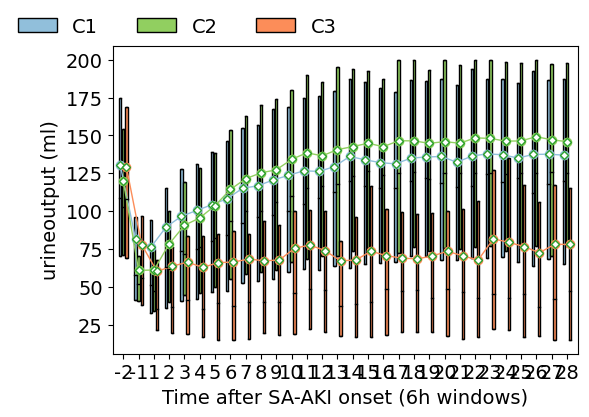

In [10]:
import matplotlib.pyplot as plt

fea_lst = [ "urineoutput"] #"urineoutput",creatinine
lab_dict = {"urineoutput": "urineoutput (ml)",  "creatinine": "creatinine (mg/dl)","wbc":"wbc"}
give_bound = False
for fea in fea_lst:
    df_fea = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/01.MIMICIV_SAKI_trajCluster/sk_feature_timescale_Fb2.csv")
    #df_fea["creatinine"] *= 88.4
    choose_time_lst = [-2,-1,1,5,9,13,17,21,25] #[-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27] #[-2,-1,1,4,7,10,13,16]
    choose_time_lst = [-2,-1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
    df_fea =  df_fea[df_fea["time"].isin(choose_time_lst)] 
    df = pd.merge(df_type_filt,df_fea, how="inner",on="stay_id")
    df1 = df[df["groupHPD"]==1][[fea,"time"]]
    df2 = df[df["groupHPD"]==2][[fea,"time"]]
    df3 = df[df["groupHPD"]==3][[fea,"time"]]
    dataframes1 = [group[1] for group in df1.groupby('time')]
    dataframes2 = [group[1] for group in df2.groupby('time')]
    dataframes3 = [group[1] for group in df3.groupby('time')]
    fig = plt.figure(figsize=(6,4))
    choose_time_lst_x = range(-1,len(choose_time_lst)-1) #[-1,0,1,2,3,4,5,6]
    choose_time_lst1 = [i-0.2 for i in choose_time_lst_x]
    choose_time_lst2 = choose_time_lst_x
    choose_time_lst3 = [i+0.2 for i in choose_time_lst_x]
    medianprops = dict(linestyle='-', linewidth=1, color='black') #中位线设置
    meanprops = dict(color='b', markersize=4,marker="D",markerfacecolor="white")
    color_lst = ['#91bfdb','#91cf60','#fc8d59']
    boxprops1 = dict(color='black',facecolor=color_lst[0],edgecolor="black") #91bfdb
    boxprops2 = dict(color='black',facecolor=color_lst[1],edgecolor="black") #91cf60
    boxprops3 = dict(color='black',facecolor=color_lst[2],edgecolor="black") #fc8d59
    pa = plt.boxplot([df[fea] for df in dataframes1],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops1, positions=choose_time_lst1,patch_artist=True,meanprops=meanprops, medianprops=medianprops) # ,notch=True
    pb = plt.boxplot([df[fea] for df in dataframes2],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops2,positions=choose_time_lst2,patch_artist=True,meanprops=meanprops, medianprops=medianprops)
    pc = plt.boxplot([df[fea] for df in dataframes3],whis=(25,75),showfliers=False,showmeans=True, meanline=False,widths=0.15,boxprops=boxprops3,positions=choose_time_lst3,patch_artist=True,meanprops=meanprops, medianprops=medianprops)
    # 加添平均值的线图
    mean_points = [pa['means'][i].get_xydata()[0] for i in range(len(pa['means']))]
    print("C1",min([p[1] for p in mean_points]),max([p[1] for p in mean_points]))
    print(len([p[1] for p in mean_points]),[p[1] for p in mean_points])
    print("\n")
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[0])
    mean_points = [pb['means'][i].get_xydata()[0] for i in range(len(pb['means']))]
    print("C2",min([p[1] for p in mean_points]),max([p[1] for p in mean_points]))
    print(len([p[1] for p in mean_points]),[p[1] for p in mean_points])
    print("\n")
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[1])
    mean_points = [pc['means'][i].get_xydata()[0] for i in range(len(pc['means']))]
    print("C3",min([p[1] for p in mean_points]),max([p[1] for p in mean_points]))
    print(len([p[1] for p in mean_points]),[p[1] for p in mean_points])
    plt.plot([p[0] for p in mean_points], [p[1] for p in mean_points], 'ro-', linewidth=1,color=color_lst[2])
    if give_bound == True:
        min_V = fea_min_dict[fea]
        max_V = fea_max_dict[fea]
        plt.hlines(y=[min_V,max_V], xmin=-1, xmax=6, color='#bdbdbd',linestyles="dashed")
        
    label_lst = ["C1", "C2", "C3"]
    plt.legend([pa["boxes"][0], pb["boxes"][0], pc["boxes"][0]], ["C1", "C2", "C3"] ,bbox_to_anchor=(0.52,1.15),ncol=3,frameon=False,fontsize=14)

    x_position= choose_time_lst_x
    x_position_fmt=choose_time_lst
    plt.xticks(x_position, x_position_fmt,fontsize=14)
    plt.yticks(fontsize=14)
#    plt.title("MIMIC IV")
    plt.xlabel('Time after SA-AKI onset (6h windows)',fontsize=14)
    plt.ylabel(lab_dict[fea],fontsize=14)
    tit = "./result/MIMIC_" + fea + ".pdf"
    plt.savefig(tit)
    plt.show()

# 每时刻AKI stages的变化+生存状态 - 6h

## 每时刻死亡与否的变化 -  6h 
- 时间长度统一

In [11]:
df_sur = pd.read_csv("./sk_survival.csv")
df_sur["survival_168H"] = df_sur["survival_28day"] * 4
df_sur = df_sur.loc[:,["stay_id", "groupHPD", "survival_168H","mortality_28d"]]  # survival_168H即院内生存时间

com_lst = []
for i in df_sur.stay_id.unique().tolist():
    for j in range(-2,29,1):
        com_lst.append([i,j])
df_com = pd.DataFrame(com_lst,columns=["stay_id", "time"])            

df_sur_ = pd.merge(df_com, df_sur, how="inner", on="stay_id")
df_sur_["survival_state"] = 0
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"
df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==1),"survival_state"]  = "D"
df_sur_ = df_sur_.loc[:,["stay_id","time","survival_state"]]
df_sur_.head(2)

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-b1de25902839>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'A' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sur_.loc[(df_sur_["time"]>=df_sur_["survival_168H"])& (df_sur_["mortality_28d"]==0),"survival_state"]  = "A"


,stay_id,time,survival_state
0,37510196.0,-2,0
1,37510196.0,-1,0


## 每时刻AKI stages的变化 -  6h 

In [12]:
select_time_lst = [0,1,5,9,13,17,21,25,28]  
import math
map_dict ={}
map_dict[0] = "Onset"
for i in range(1,29,1):
    j = "D" + str(math.ceil(i/4)) + "_" + str(i%4)
    map_dict[i] = j.replace("_0","_4")
    
xticks = [ map_dict[i] for i in select_time_lst]
print(xticks)

['Onset', 'D1_1', 'D2_1', 'D3_1', 'D4_1', 'D5_1', 'D6_1', 'D7_1', 'D7_4']


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# 补齐28个stages
df_stage = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic//disease_definition/AKI/kdigo_stages_based_time.csv")

# 用生存和死亡补齐没有AKI stages记录的点
tmp_df = pd.merge(df_stage, df_sur_, how="right", on= ["stay_id","time"])
tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
tmp_df.loc[tmp_df["aki_stage"]=="A","aki_stage"] = 5
tmp_df.loc[tmp_df["aki_stage"]=="D","aki_stage"] = 4

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-13-007c63978ed8>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tmp_df["aki_stage"].fillna(tmp_df["survival_state"],inplace=True)
<ipyth

In [14]:
# map_dict = {0:"NO_AKI",1:"AKI_I",2:"AKI_II",3:"AKI_III", 4:"Died",5:"Alive"}
# tmp_df = df_aki_all
# tmp_df["label"] = tmp_df["aki_stage"].map(map_dict)
# tmp_df = tmp_df[tmp_df["time"].isin([0,5,9,13,17,21,25])]
# map_dict = {0:1, 5:2,9:3,13:4, 17:5, 21:6, 25:7}
# tmp_df["time_day"] = tmp_df["time"].map(map_dict)
# tmp_df.to_csv("data_for_alluvial.csv",index=False)
# tmp_df.head()

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# 对每个时间点 每个类群 每个阶级的患者数量
df_aki_all = tmp_df
df_aki_all = pd.merge(df_aki_all,df_type_filt, how="inner",on="stay_id")
df_aki_all = df_aki_all.loc[:,['stay_id', 'time', 'aki_stage', 'groupHPD']]
df_aki_all = df_aki_all.groupby(["time","groupHPD","aki_stage"]).agg("count").reset_index()

# 构建一个完整的关于 # time -2-29
# aki_stage 0-3
# groupHPD 1-3
# 的一个dataframe
com_lst = []
for i in range(-2,29,1): # time
    for j in range(0,6,1): # aki_stage
        for k in range(1,4,1): # groupHPD
            com_lst.append([i,j,k])
df_com = pd.DataFrame(com_lst,columns=["time", "aki_stage", "groupHPD"])            
df_aki_all = pd.merge(df_com, df_aki_all, how="left", on=["time","aki_stage", "groupHPD"])
df_aki_all = df_aki_all.fillna(0)

df_stayid_sum = pd.DataFrame(df_type_filt["groupHPD"].value_counts()).reset_index()
df_stayid_sum.columns = [ 'groupHPD', 'stay_id_sum']

df_aki_all_ = pd.merge(df_aki_all, df_stayid_sum, how="inner", on=["groupHPD"])
df_aki_all_["percent"] = round(df_aki_all_["stay_id"]/df_aki_all_["stay_id_sum"]*100,2)
df_aki_all_ = df_aki_all_[df_aki_all_["time"].isin(select_time_lst)]


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


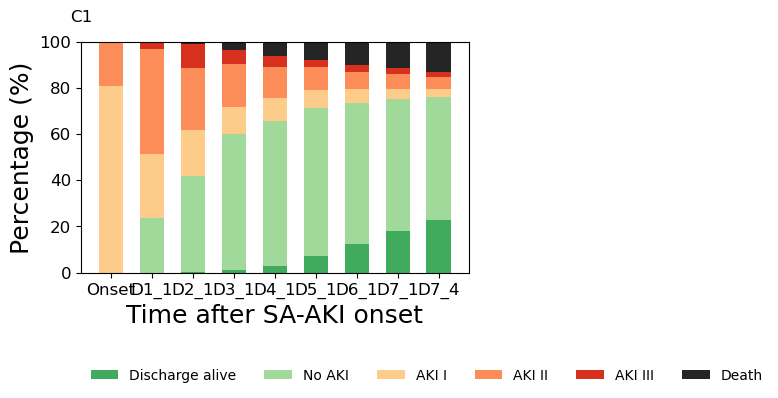

In [16]:
df1 = df_aki_all_[df_aki_all_["groupHPD"] ==1]
df2 = df_aki_all_[df_aki_all_["groupHPD"] ==2]
df3 = df_aki_all_[df_aki_all_["groupHPD"] ==3]

import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df1 
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False)
plt.title('C1',x=0,y=1.05) # MIMIC - C1
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/MIMIC_C1_AKIstages.pdf', bbox_inches = 'tight')
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


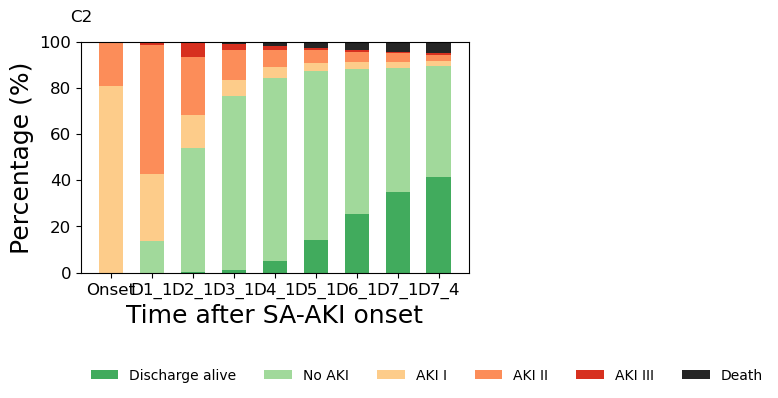

In [17]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df2
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False)
plt.title('C2',x=0,y=1.05) # MIMIC - 
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/MIMIC_C2_AKIstages.pdf', bbox_inches = 'tight')
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


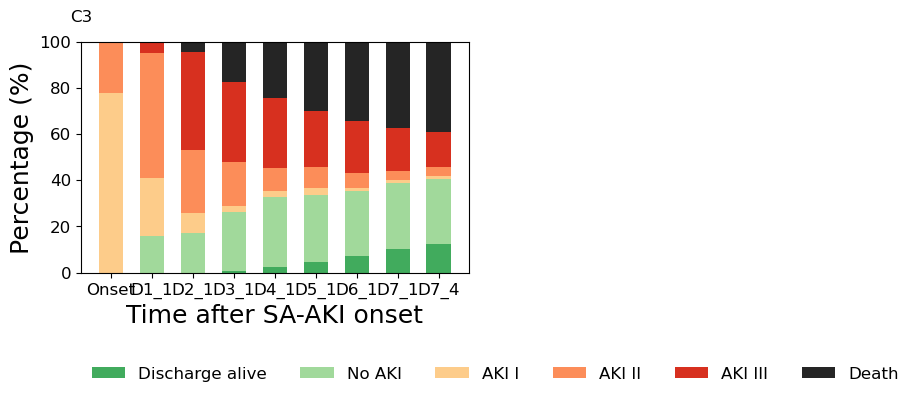

In [18]:
import numpy as npd
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3)) 
ind = df_aki_all_.time.unique().tolist()
ind = sorted(range(len(ind)))
plt.xticks(ind, xticks)

df = df3
AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

width = 0.6  
p0 = plt.bar(ind, alive, width=width, color ='#41ab5d') #  '#a1d99b'
p1 = plt.bar(ind, AKI0,bottom=alive, width = width, color='#a1d99b')  # '#e5f5e0'
p2 = plt.bar(ind, AKI1, width=width, bottom=alive+ AKI0,color='#fdcc8a')  
p3 = plt.bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1,color='#fc8d59')
p4 = plt.bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2,color='#d7301f')
p5 = plt.bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3,color='#252525') ##a63603

plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]), ('Discharge alive','No AKI', 'AKI I', 'AKI II', 'AKI III','Death'),
           bbox_to_anchor=(0.01,-0.5),loc = 3, borderaxespad=0,ncol=6,frameon=False,fontsize=12)
plt.title('C3',x=0,y=1.05)
plt.xlabel("Time after SA-AKI onset",fontsize=18) # (6h windows)
plt.ylabel("Percentage (%)",fontsize=18)
plt.yticks(np.arange(0, 110, 20),fontsize=12)
plt.xticks(fontsize=12)
plt.savefig('./result/MIMIC_C3_AKIstages.png', bbox_inches = 'tight', dpi=300)
plt.savefig('./result/MIMIC_C3_AKIstages.pdf', bbox_inches = 'tight', dpi=300)
plt.show()


/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


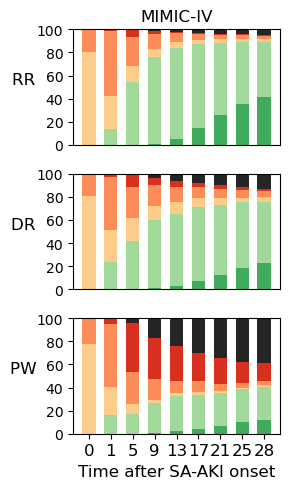

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(3, 5), sharex=True)

for i, df in enumerate([ df2,df1, df3]):
    ind = df_aki_all_.time.unique().tolist()
    ind = sorted(range(len(ind)))

    AKI0 = np.array(df[df["aki_stage"]==0]["percent"].tolist())
    AKI1 = np.array(df[df["aki_stage"]==1]["percent"].tolist())
    AKI2 = np.array(df[df["aki_stage"]==2]["percent"].tolist())
    AKI3 = np.array(df[df["aki_stage"]==3]["percent"].tolist())
    Died = np.array(df[df["aki_stage"]==4]["percent"].tolist())
    alive = np.array(df[df["aki_stage"]==5]["percent"].tolist())

    width = 0.6
    p0 = axs[i].bar(ind, alive, width=width, color='#41ab5d')
    p1 = axs[i].bar(ind, AKI0, bottom=alive, width=width, color='#a1d99b')
    p2 = axs[i].bar(ind, AKI1, width=width, bottom=alive + AKI0, color='#fdcc8a')
    p3 = axs[i].bar(ind, AKI2, width=width, bottom=alive + AKI0 + AKI1, color='#fc8d59')
    p4 = axs[i].bar(ind, AKI3, width=width, bottom=alive + AKI0 + AKI1 + AKI2, color='#d7301f')
    p5 = axs[i].bar(ind, Died, width=width, bottom=alive + AKI0 + AKI1 + AKI2 + AKI3, color='#252525')

    axs[0].set_ylabel("RR   ", fontsize=12,rotation=0)
    axs[1].set_ylabel("DR   ", fontsize=12,rotation=0)
    axs[2].set_ylabel("PW   ", fontsize=12,rotation=0)
    axs[i].set_yticks(np.arange(0, 110, 20), fontsize=12)
    axs[0].set_title("MIMIC-IV")
    axs[i].set_xticks([])
    axs[0].tick_params(axis='x', which='both', bottom=False)
    axs[1].tick_params(axis='x', which='both', bottom=False)
        
plt.xlabel("Time after SA-AKI onset", fontsize=12)
#plt.ylabel("Percentage (%)")
plt.xticks(ind, select_time_lst, fontsize=12)
# plt.legend((p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]),
#                   ('Discharge alive', 'No AKI', 'AKI I', 'AKI II', 'AKI III', 'Death'),
#                   bbox_to_anchor=(0.01, 3.5), loc=3, borderaxespad=0, ncol=6, frameon=False)
plt.subplots_adjust(hspace=0.01)
plt.tight_layout()

plt.savefig('./result/MIMIC_Combined_AKIstages.png', bbox_inches='tight', dpi=300)
plt.savefig('./result/MIMIC_Combined_AKIstages.pdf', bbox_inches='tight', dpi=300)
plt.show()


In [20]:
sss

/home/hanl/miniconda3/envs/mytensor/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'sss' is not defined

# 每天尿量和肌酐正常与异常的占比变化
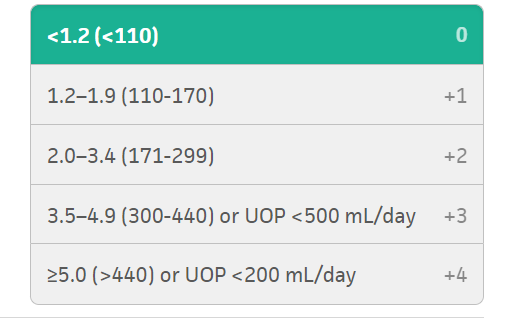

In [ ]:
df_uo = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/feature_data/sk_icu_feature.csv",usecols=["stay_id","charttime","urineoutput","creatinine"])
df_uo = df_uo[df_uo["stay_id"].isin(all_lst)] 
df_uo["charttime"] = pd.to_datetime(df_uo["charttime"])
df_uo = df_uo.dropna(how='all', subset=['urineoutput',"creatinine"])

#  condition1: -4 <= time <= 28
df_time=pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype_v3/00.data_mimic/disease_definition/AKI/sk_event_time.csv")
df_time = df_time.loc[:,["stay_id", "saki_onset"]]
df_time["saki_onset"] = pd.to_datetime(df_time["saki_onset"])

df_uo_add = pd.merge(df_uo, df_time, how="inner", on="stay_id")
df_uo_add["time"] = (df_uo_add["charttime"] - df_uo_add["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_uo_add["time"] = df_uo_add["time"].map(lambda x:x//1) # -1指sepsis前6小时的数据，0指sepsis后第一个6小时的数据
df_uo_add["time"] = df_uo_add["time"].map(lambda x: x+1 if x>=0 else x)
df_uo_add = df_uo_add[(df_uo_add["time"]>=-2) &(df_uo_add["time"]<=7)]
df_uo_add = df_uo_add.drop(["charttime","saki_onset"],axis=1)
df_uo_add = df_uo_add.groupby(["stay_id","time"]).agg({"urineoutput":"sum","creatinine":"mean"}).reset_index()

df_fea  = df_uo_add
df_fea = pd.merge(df_fea,df_type_filt,how="inner",on="stay_id")
df_fea["time"] = df_fea["time"].astype("int")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cu(df,fea):
    fig, ax = plt.subplots(figsize=(4,3))
    grouped_data = df.groupby(['time', fea]).size().unstack()

    grouped_data_percentage = grouped_data.div(grouped_data.sum(axis=1), axis=0)
    grouped_data_percentage.plot(kind='bar', stacked=True, ax=ax)

    plt.title(fea)
    plt.xlabel('Time')
    plt.ylabel('Proportion')
#     plt.xticks([-2,1,9,25],[-1,1,3,7], rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.8),frameon=False,labels=["normal","abnomal"])
    plt.show()
    
df_fea["creatinine_type"] = 0
df_fea.loc[df_fea["creatinine"]>=1.2,"creatinine_type"] = 1

df_fea["uo_type"] = 0
df_fea.loc[df_fea["urineoutput"]<400,"uo_type"] = 1
df_fea.head(1)

In [ ]:
fea = "uo_type" 
df = df_fea[df_fea["groupHPD"]==1]
plot_cu(df,fea)

fea = "uo_type" 
df = df_fea[df_fea["groupHPD"]==2]
plot_cu(df,fea)

fea = "uo_type" 
df = df_fea[df_fea["groupHPD"]==3]
plot_cu(df,fea)

In [ ]:
fea = "creatinine_type" 
df = df_fea[df_fea["groupHPD"]==1]
plot_cu(df,fea)

fea = "creatinine_type" 
df = df_fea[df_fea["groupHPD"]==2]
plot_cu(df,fea)

fea = "creatinine_type" 
df = df_fea[df_fea["groupHPD"]==3]
plot_cu(df,fea)

# saki 发作后12h的临床特征

In [ ]:
#by 差值
def data_get(df):
    df = df.groupby("groupHPD").agg(["mean","sem"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df.reset_index()
    df = df.drop(["stay_id_mean","stay_id_sem"],axis=1)
    
    # 按C1,C3组差值来排序
    tmp_df = df.T
    tmp_df["C3_C2"] = tmp_df[2] - tmp_df[1]
    tmp_df = tmp_df.sort_values(["C3_C2"]).T

    from matplotlib import pyplot as plt 
    f_mean = [i for i in tmp_df.columns if i.endswith("_mean")]
    f_sem = [i for i in tmp_df.columns if i.endswith("_sem")]

    import re
    #f_mean = [i for i in tmp_df.columns if i.endswith("_mean")]
    #f_sem = [re.sub("_mean$","_sem",i) for i in f_mean ]
    col_lst = [re.sub("_mean$","",i) for i in f_mean ]
    return df,f_mean, f_sem, col_lst

In [ ]:
# by 自定义
def data_get(df):
    df = df.groupby("groupHPD").agg(["mean","sem"])
    df.columns = ['_'.join(col) for col in df.columns]
    df = df.reset_index()
    df = df.drop(["stay_id_mean","stay_id_sem"],axis=1)

    sort_lst = ["urineoutput","ph","baseexcess","bicarbonate","totalco2","albumin",
                "sbp","mbp","dbp",'temperature',"pao2fio2ratio","spo2", "po2","pco2", "chloride","calcium",
                "platelet","mchc","rbc","mch","mcv","hematocrit","wbc"
           ,"alp","alt","ast","bilirubin_total",'heart_rate',"resp_rate","rdw","potassium","fio2","pt","ptt","inr",
             "aado2", "aniongap","lactate","bun","creatinine"]
    import re
    #f_mean = [i for i in tmp_df.columns if i.endswith("_mean")]
    f_mean = [i+"_mean" for i in sort_lst]
    f_sem = [re.sub("_mean$","_sem",i) for i in f_mean ]
    col_lst = [re.sub("_mean$","",i) for i in f_mean ]
    return df,f_mean, f_sem, col_lst

In [ ]:
def fea_plot(df):
    label_lst = ["C1", "C2", "C3"]
    x_len = list(range(0,len(f_mean),1))

    df1 = df[df["groupHPD"]==1]
    x1 = x_len
    y1 =  np.array(df1[f_mean])[0]
    std1 = np.array(df1[f_sem])[0]

    df2 = df[df["groupHPD"]==2]
    x2 = x_len 
    y2 =  np.array(df2[f_mean])[0]
    std2 = np.array(df2[f_sem])[0]


    df3 = df[df["groupHPD"]==3]
    x3 = x_len
    y3 =  np.array(df3[f_mean])[0]
    std3 = np.array(df3[f_sem])[0]

    plt.figure(figsize=(16, 8)) 
    plt.errorbar(x1,y1,yerr=std1,fmt='o-',ecolor='r',color='#1b9e77',elinewidth=2,capsize=4)
    plt.errorbar(x2,y2,yerr=std2,fmt='o-',ecolor='r',color='#d95f02',elinewidth=2,capsize=4)
    plt.errorbar(x3,y3,yerr=std3,fmt='o-',ecolor='r',color='#7570b3',elinewidth=2,capsize=4)
    plt.xticks(x_len, col_lst, rotation = 80)
    plt.xlabel("feature",fontsize=15)
    plt.ylabel("value",fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(label_lst)
    plt.show()

In [ ]:
# 获取特征
df_fea_6h = pd.read_csv("./sk_feature_timescale_Fb2.csv",nrows = 10)
df_fea_6h = df_fea_6h.drop([ 'time', "crea_divide_basecrea"], axis=1)
fea_lst = df_fea_6h.columns.tolist()

# 获取saki后12小时的数据
data_dir = "/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/feature_data/"
infile = data_dir + "sk_icu_feature.csv"
df_fea = pd.read_csv(infile)
df_fea = df_fea[df_fea["stay_id"].isin(all_lst)] 
df_fea["charttime"] = pd.to_datetime(df_fea["charttime"])
df_fea = df_fea[df_fea["stay_id"].isin(all_lst)]
fea_lst = fea_lst + ["charttime"]
df_fea = df_fea[fea_lst]

In [ ]:
# 取第一个12小时的数据并标化
df_aki = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/disease_definition/sk_event_time.csv")
df_cut = df_aki.loc[:,["stay_id", "saki_onset"]]
df_cut["saki_onset"] = pd.to_datetime(df_cut["saki_onset"])
df_fea_add = pd.merge(df_fea, df_cut, how="inner", on="stay_id")
df_fea_add["time"] = (df_fea_add["charttime"] - df_fea_add["saki_onset"]).map(lambda x:x/np.timedelta64(24, 'h')).tolist()
df_fea_add["time"] = df_fea_add["time"].map(lambda x:x//1) # -1指sepsis前6小时的数据，0指sepsis后第一个6小时的数据
df_fea_add["time"] = df_fea_add["time"].map(lambda x: x+1 if x>=0 else x)
df_fea_add = df_fea_add[df_fea_add["time"].isin([1])]
df_fea_add = df_fea_add.drop(["charttime","saki_onset"],axis=1)
df_fea_add = df_fea_add.groupby(["stay_id","time"]).agg("mean").reset_index()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #针对每一个特征维度来做的
df_fea_std = scaler.fit_transform(df_fea_add) 
df_fea_std =  pd.DataFrame(df_fea_std)
df_fea_std.columns = df_fea_add.columns.tolist()
df_fea_std =  df_fea_std.drop(["stay_id","time"],axis=1)
df_fea_std.reset_index(drop=True, inplace=True)
df_type_filt.reset_index(drop=True, inplace=True)
df_fea_std = pd.concat([df_type_filt, df_fea_std],axis=1)

In [ ]:
#bg_fea = ["so2","po2","pco2","fio2","ph","baseexcess","bicarbonate", "hematocrit", "calcium", "potassium", "lactate", "glucose"] 
vital = ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate','temperature']
acidbase = ["totalco2","bicarbonate", "baseexcess", "ph", "lactate","pco2","aniongap"]
oxygen = ["spo2", "po2", "pao2fio2ratio", "aado2", "fio2"]
liver = ['alt', 'alp', 'ast',  "bilirubin_total", "albumin"]
kidney = [ 'bun', 'creatinine',"urineoutput"]
blood = ["rbc", "hemoglobin", "mchc", "platelet", "hematocrit","mch", "rdw", "mcv", "wbc"]
coagulation = ["inr", "pt", "ptt"]
chem = ["potassium", "calcium", "chloride"]
gcs = ["gcs_verbal", "gcs_eyes", "gcs_motor"]
oth = ['stay_id', 'groupHPD']

merge_fea = vital + acidbase + oxygen + liver +kidney +blood +coagulation +chem+oth
df_fea_std_fealst = df_fea_std.columns.tolist()
all_fea  = list(set(df_fea_std_fealst).intersection(set(merge_fea)))

In [ ]:
data = df_fea_std[all_fea]
df,f_mean, f_sem, col_lst = data_get(data)
fea_plot(df)

In [ ]:
data = df_fea_std.loc[:,['stay_id', 'groupHPD','sofa', 'respiration_sofa',
       'coagulation_sofa', 'liver_sofa', 'cardiovascular_sofa', 'cns_sofa',
       'renal_sofa']]
df,f_mean, f_sem, col_lst = data_get(data)
fea_plot(df)

# 倾向性数据生成

In [ ]:
df_demo =  pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/feature_data/sk_icu_basicinfo.csv")
df_demo = df_demo.loc[:,['stay_id', 'age', 'first_careunit']]
df_demo = df_demo[df_demo["stay_id"].isin(all_lst)]

df_disease = pd.read_csv("/public/hanl/jupyter_dir/kidney_sepsis_penotype/00.data/diag_icd/df_diag_icd.csv")
df_disease["stay_id"] = df_disease["stay_id"].astype("int64")

df_match = pd.merge(df_demo, df_disease, how="left", on="stay_id")
df_match = df_match.fillna(0)
df_match = pd.merge(df_match,df_type_filt, how="inner",on="stay_id")
df_match.to_csv("df_match_fea.csv", index=False)